# Esercitazione Mongo DB - Setup

In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import csv
import json
import time

#read db credentials from config file
with open('config.json') as f:
    data = json.load(f)
    db_user = data['user']
    db_password = data['password']
    filename = data['filename']

#connect to the database
client: MongoClient = MongoClient('localhost', 27017, username=db_user, password=db_password)

db = client['exercise1']
coll_name = ['U', 'UA', 'A']
trash_coll = 'Trash'
year_col = 'Released_Year'
rating_col = 'IMDB_Rating'
certificate_col = 'Certificate'
all_films_coll = 'All'

speedups = {}

def print_beautify(text):
    print(json.dumps(text, indent=4))


# Save to DB

In [2]:
def save_films_to_db(filemame):
    with open(file=filemame, mode='r') as file:
        reader = csv.DictReader(file, delimiter=',')

        #create collections based on the certificate or clear the existing ones
        db[trash_coll].drop()
        db.create_collection(trash_coll)
        for name in coll_name:
            if name in db.list_collection_names():
                db[name].drop()
                db.create_collection(name)
        db[all_films_coll].drop()
        db.create_collection(all_films_coll)

        for row in reader:
            # exclude films with different certificate, year less than 1980 and rating less than 8
            if certificate_col in row and year_col in row and rating_col in row:
                try:
                    row[year_col] = int(row[year_col])
                    row[rating_col] = float(row[rating_col])
                except ValueError:
                    db[trash_coll].insert_one(row)
                    continue
                if row[certificate_col] in coll_name and row[year_col] >= 1980 and row[rating_col] >= 8:
                    # insert the film to the corresponding collection
                    db[row['Certificate']].insert_one(row)
                    # insert the film to the 'All' collection
                    db[all_films_coll].insert_one(row)
                else:
                    db[trash_coll].insert_one(row)
            else:
                db[trash_coll].insert_one(row)

        print('Films are correctly saved to the database')

save_films_to_db(filename)

Films are correctly saved to the database


# Query 1

**find all films published after 2015 grouped by genre. visualise an istogram with the number of films for each genre**

In [3]:
def question1():
    pipeline = [
        {'$match': {year_col: {'$gt': 2015}, 'Genre': {'$exists': True}}},
        {"$project": {"Genre": {"$map": {"input": {"$split": ["$Genre", ","]}, "as": "g","in": {"$trim": { "input": "$$g" }}}}}},
        {'$unwind': '$Genre'},
        {'$group': {'_id': '$Genre', 'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}
    ]
    now = time.time()
    genres = {}
    for coll in coll_name:
        part_genres = list(db[coll].aggregate(pipeline))
        # print(part_genres, '\n')
        for genre in part_genres:
            if genre['_id'] in genres:
                genres[genre['_id']] += genre['count']
            else:
                genres[genre['_id']] = genre['count']
    
    
    genres = dict(sorted(genres.items(), key=lambda item: item[1], reverse=True))
    elapsed1 = time.time() - now
    print('Time on separate collection: ', elapsed1, '\n')

    # do the same but for the 'All' collection
    now = time.time()
    all_genres = list(db[all_films_coll].aggregate(pipeline))
    all_genres = dict(sorted({genre['_id']: genre['count'] for genre in all_genres}.items(), key=lambda item: item[1], reverse=True))
    elapsed2 = time.time() - now
    print('Time on aggregate collection: ', elapsed2, '\n')

    speedup = (elapsed1 / elapsed2) * 100
    speedups[question1.__code__.co_name] = speedup
    print('Speedup: ', speedup, '%\n')
    return genres, all_genres


genres, all_genres = question1()

Time on separate collection:  0.005576610565185547 

Time on aggregate collection:  0.0017926692962646484 

Speedup:  311.0786008777763 %



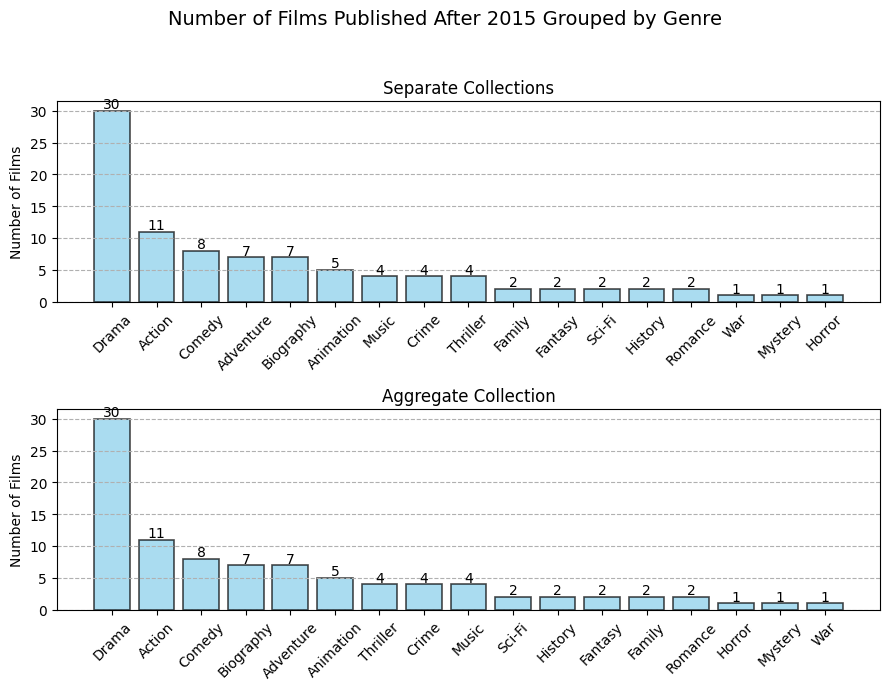

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(9, 7)) 
fig.suptitle('Number of Films Published After 2015 Grouped by Genre', fontsize=14)

# First subplot: Separate collections
axs[0].bar(genres.keys(), genres.values(), color='skyblue', edgecolor='black', linewidth=1.2, alpha=0.7)
axs[0].set_title('Separate Collections', fontsize=12)
axs[0].set_ylabel('Number of Films', fontsize=10)
axs[0].grid(axis='y', linestyle='--', which='major')
for i, v in enumerate(genres.values()):
    axs[0].text(i, v + 0.4, str(v), color='black', ha='center')
axs[0].tick_params(axis='x', rotation=45)

# Second subplot: Aggregate collection
axs[1].bar(all_genres.keys(), all_genres.values(), color='skyblue', edgecolor='black', linewidth=1.2, alpha=0.7)
axs[1].set_title('Aggregate Collection', fontsize=12)
axs[1].set_ylabel('Number of Films', fontsize=10)
axs[1].grid(axis='y', linestyle='--', which='major')
for i, v in enumerate(all_genres.values()):
    axs[1].text(i, v + 0.4, str(v), color='black', ha='center')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Query 2

**find the top 5 films for each genre based on the IMDB rating**

In [5]:
def question2():
    pipeline = [
        {
            "$project": {
                "Genre": {
                    "$map": {
                        "input": {"$split": ["$Genre", ","]},
                        "as": "g",
                        "in": {"$trim": {"input": "$$g"}}
                    }
                },
                "Series_Title": 1,
                "IMDB_Rating": 1
            }
        },
        {"$unwind": "$Genre"},
        {"$sort": {"IMDB_Rating": -1, "Series_Title": 1}},
        {
            "$group": {
                "_id": "$Genre",
                "films": {
                    "$push": {"Series_Title": "$Series_Title", "IMDB_Rating": "$IMDB_Rating"}
                }
            }
        },
        {
            "$project": {
                "_id": 0,
                "Genre": "$_id",
                "films": {"$slice": ["$films", 5]}
            }
        }
    ]
    
    now = time.time()
    top_films = {}
    for coll in coll_name:
        part_top_films = list(db[coll].aggregate(pipeline))
        for genre in part_top_films:
            if genre['Genre'] in top_films:
                top_films[genre['Genre']].extend(genre['films'])
            else:
                top_films[genre['Genre']] = genre['films']
    
    for genre in top_films:
        top_films[genre] = sorted(top_films[genre], key=lambda x: x['IMDB_Rating'], reverse=True)[:5]

    # order by genre
    top_films = dict(sorted(top_films.items(), key=lambda item: item[0]))
    elapsed1 = time.time() - now
    
    print_beautify(top_films)
    print("Time on separate collection: ", elapsed1, '\n')

    # do the same but for the 'All' collection
    now = time.time()
    all_top_films = list(db[all_films_coll].aggregate(pipeline))
    all_top_films = {genre['Genre']: genre['films'] for genre in all_top_films}
    for genre in all_top_films:
        all_top_films[genre] = sorted(all_top_films[genre], key=lambda x: x['IMDB_Rating'], reverse=True)[:5]
    all_top_films = dict(sorted(all_top_films.items(), key=lambda item: item[0]))
    elapsed2 = time.time() - now

    print_beautify(all_top_films)
    print("Time on aggregate collection: ", elapsed2, '\n')

    speedup = (elapsed1 / elapsed2) * 100
    speedups[question2.__code__.co_name] = speedup
    print('Speedup: ', speedup, '%\n')

question2()

{
    "Action": [
        {
            "Series_Title": "The Dark Knight",
            "IMDB_Rating": 9.0
        },
        {
            "Series_Title": "The Lord of the Rings: The Return of the King",
            "IMDB_Rating": 8.9
        },
        {
            "Series_Title": "The Lord of the Rings: The Fellowship of the Ring",
            "IMDB_Rating": 8.8
        },
        {
            "Series_Title": "Inception",
            "IMDB_Rating": 8.8
        },
        {
            "Series_Title": "Star Wars: Episode V - The Empire Strikes Back",
            "IMDB_Rating": 8.7
        }
    ],
    "Adventure": [
        {
            "Series_Title": "The Lord of the Rings: The Return of the King",
            "IMDB_Rating": 8.9
        },
        {
            "Series_Title": "The Lord of the Rings: The Fellowship of the Ring",
            "IMDB_Rating": 8.8
        },
        {
            "Series_Title": "Inception",
            "IMDB_Rating": 8.8
        },
        {
        

# Query 3

**get the newest and oldest film for each genre**

In [6]:
def question3():
    pipeline = [
        {
            "$project": {
                "Genre": {
                    "$map": {
                        "input": {"$split": ["$Genre", ","]},
                        "as": "g",
                        "in": {"$trim": {"input": "$$g"}}
                    }
                },
                "Series_Title": 1,
                "Released_Year": 1
            }
        },
        {"$unwind": "$Genre"},
        {"$sort": {"Released_Year": 1, "Series_Title": 1}},
        {
            "$group": {
                "_id": "$Genre",
                "newest": {"$last": {"Series_Title": "$Series_Title", "Released_Year": "$Released_Year"}},
                "oldest": {"$first": {"Series_Title": "$Series_Title", "Released_Year": "$Released_Year"}}
            }
        },
        {
            "$project": {
                "_id": 0,
                "Genre": "$_id",
                "newest": 1,
                "oldest": 1
            }
        }
    ]

    now = time.time()
    films = {}
    for coll in coll_name:
        part_films = list(db[coll].aggregate(pipeline))
        for genre in part_films:
            if genre['Genre'] in films:
                if genre['newest']['Released_Year'] > films[genre['Genre']]['newest']['Released_Year']:
                    films[genre['Genre']]['newest'] = genre['newest']
                if genre['oldest']['Released_Year'] < films[genre['Genre']]['oldest']['Released_Year']:
                    films[genre['Genre']]['oldest'] = genre['oldest']
            else:
                films[genre['Genre']] = {'newest': genre['newest'], 'oldest': genre['oldest']}
    
    # order by genre
    films = dict(sorted(films.items(), key=lambda item: item[0]))
    elapsed1 = time.time() - now

    print_beautify(films)
    print("Time on separate collection: ", elapsed1, '\n')

    # do the same but for the 'All' collection
    now = time.time()
    all_films = list(db[all_films_coll].aggregate(pipeline))
    all_films = {genre['Genre']: {'newest': genre['newest'], 'oldest': genre['oldest']} for genre in all_films}
    all_films = dict(sorted(all_films.items(), key=lambda item: item[0]))
    elapsed2 = time.time() - now

    print_beautify(all_films)
    print("Time on aggregate collection: ", elapsed2, '\n')

    # print the speedup using the 'All' collection
    speedup = (elapsed1 / elapsed2) * 100
    speedups[question3.__code__.co_name] = speedup
    print('Speedup: ', speedup, '%\n')

question3()

{
    "Action": {
        "newest": {
            "Series_Title": "Ford v Ferrari",
            "Released_Year": 2019
        },
        "oldest": {
            "Series_Title": "Star Wars: Episode V - The Empire Strikes Back",
            "Released_Year": 1980
        }
    },
    "Adventure": {
        "newest": {
            "Series_Title": "Soul",
            "Released_Year": 2020
        },
        "oldest": {
            "Series_Title": "Star Wars: Episode V - The Empire Strikes Back",
            "Released_Year": 1980
        }
    },
    "Animation": {
        "newest": {
            "Series_Title": "Soul",
            "Released_Year": 2020
        },
        "oldest": {
            "Series_Title": "Kaze no tani no Naushika",
            "Released_Year": 1984
        }
    },
    "Biography": {
        "newest": {
            "Series_Title": "Togo",
            "Released_Year": 2019
        },
        "oldest": {
            "Series_Title": "The Elephant Man",
            "Relea

# Query 4

**get the oldest film with the highest rating**

In [7]:
def question4():
    pipeline = [
        {
            "$project": {
                "Series_Title": 1,
                "Released_Year": 1,
                "IMDB_Rating": 1
            }
        },
        {"$sort": {"Released_Year": 1, "IMDB_Rating": -1}},
        {"$limit": 1}
    ]
    now = time.time()
    oldest = {}
    for coll in coll_name:
        tmp = list(db[coll].aggregate(pipeline))[0]
        if 'Released_Year' in tmp and 'IMDB_Rating' in tmp:
            if 'Released_Year' not in oldest:
                oldest = tmp
            elif tmp['Released_Year'] < oldest['Released_Year']:
                oldest = tmp
            elif tmp['Released_Year'] == oldest['Released_Year'] and tmp['IMDB_Rating'] > oldest['IMDB_Rating']:
                oldest = tmp
    
    result = {'Series_Title': oldest['Series_Title'], 'Released_Year': oldest['Released_Year'], 'IMDB_Rating': oldest['IMDB_Rating']}
    elapsed1 = time.time() - now
    print_beautify(result)
    print("Time on separate collection: ", elapsed1, '\n')

    # do the same but for the 'All' collection
    now = time.time()
    oldest = list(db[all_films_coll].aggregate(pipeline))[0]
    result = {'Series_Title': oldest['Series_Title'], 'Released_Year': oldest['Released_Year'], 'IMDB_Rating': oldest['IMDB_Rating']}
    elapsed2 = time.time() - now
    print_beautify(result)
    print("Time on aggregate collection: ", elapsed2, '\n')

    # print the speedup using the 'All' collection
    speedup = (elapsed1 / elapsed2) * 100
    speedups[question4.__code__.co_name] = speedup
    print('Speedup: ', speedup, '%\n')


question4()

{
    "Series_Title": "Star Wars: Episode V - The Empire Strikes Back",
    "Released_Year": 1980,
    "IMDB_Rating": 8.7
}
Time on separate collection:  0.005974769592285156 

{
    "Series_Title": "Star Wars: Episode V - The Empire Strikes Back",
    "Released_Year": 1980,
    "IMDB_Rating": 8.7
}
Time on aggregate collection:  0.002028226852416992 

Speedup:  294.58093334900667 %



# Query 5

**get the firsts 5 films with longest Runtime (specified in xxx min)**

In [8]:
def question5():
    pipeline = [
        {
            "$project": {
                "Series_Title": 1,
                "Runtime": {
                    "$toInt": {
                        "$arrayElemAt": [{"$split": ["$Runtime", " "]}, 0]
                    }
                }
            }
        },
        {"$sort": {"Runtime": -1}},
        {"$limit": 5}
    ]
    now = time.time()
    longest = []
    for coll in coll_name:
        tmp = list(db[coll].aggregate(pipeline))
        for film in tmp:
            if len(longest) < 5:
                longest.append(film)
            else:
                longest = sorted(longest, key=lambda x: x['Runtime'], reverse=True)
                if film['Runtime'] > longest[4]['Runtime']:
                    longest[4] = film
    
    result = []
    for film in longest:
        result.append({'Series_Title': film['Series_Title'], 'Runtime': film['Runtime']})

    elapsed1 = time.time() - now

    print_beautify(result)
    print("Time on separate collection: ", elapsed1, '\n')

    # do the same but for the 'All' collection
    now = time.time()
    longest = list(db[all_films_coll].aggregate(pipeline))
    result = []
    for film in longest:
        result.append({'Series_Title': film['Series_Title'], 'Runtime': film['Runtime']})
    elapsed2 = time.time() - now

    print_beautify(result)
    print("Time on aggregate collection: ", elapsed2, '\n')

    # print the speedup using the 'All' collection

    speedup = (elapsed1 / elapsed2) * 100
    speedups[question5.__code__.co_name] = speedup
    print('Speedup: ', speedup, '%\n')

question5()

[
    {
        "Series_Title": "Gangs of Wasseypur",
        "Runtime": 321
    },
    {
        "Series_Title": "Once Upon a Time in America",
        "Runtime": 229
    },
    {
        "Series_Title": "Lagaan: Once Upon a Time in India",
        "Runtime": 224
    },
    {
        "Series_Title": "Swades: We, the People",
        "Runtime": 210
    },
    {
        "Series_Title": "The Lord of the Rings: The Return of the King",
        "Runtime": 201
    }
]
Time on separate collection:  0.006513118743896484 

[
    {
        "Series_Title": "Gangs of Wasseypur",
        "Runtime": 321
    },
    {
        "Series_Title": "Once Upon a Time in America",
        "Runtime": 229
    },
    {
        "Series_Title": "Lagaan: Once Upon a Time in India",
        "Runtime": 224
    },
    {
        "Series_Title": "Swades: We, the People",
        "Runtime": 210
    },
    {
        "Series_Title": "The Lord of the Rings: The Return of the King",
        "Runtime": 201
    }
]
Time on agg

# Query 6

**get the gross income for each genre. Visualise it with an histogram**

In [9]:
def question6():
    pipeline = [
    {
        "$project": {
            "Genre": {
                "$map": {
                    "input": {"$split": ["$Genre", ","]},
                    "as": "g",
                    "in": {"$trim": {"input": "$$g"}}
                }
            },
            "Gross": {
                "$toInt": {
                    "$replaceAll": {
                        "input": {
                            "$cond": {
                                "if": {"$eq": ["$Gross", ""]},
                                "then": "0",
                                "else": "$Gross"
                            }
                        },
                        "find": ",",
                        "replacement": ""
                    }
                }
            }
        }
    },
    {"$unwind": "$Genre"},
    {
        "$group": {
            "_id": "$Genre",
            "total": {"$sum": "$Gross"}
        }
    },
    {"$sort": {"total": -1}}
    ];
    now = time.time()
    genres = {}
    for coll in coll_name:
        part_genres = list(db[coll].aggregate(pipeline))
        for genre in part_genres:
            if genre['_id'] in genres:
                genres[genre['_id']] += genre['total']
            else:
                genres[genre['_id']] = genre['total']

    genres = dict(sorted(genres.items(), key=lambda item: item[1], reverse=True))
    elapsed1 = time.time() - now

    print_beautify(genres)
    print("Time on separate collection: ", elapsed1, '\n')

    # do the same but for the 'All' collection
    now = time.time()
    all_genres = list(db[all_films_coll].aggregate(pipeline))
    all_genres = dict(sorted({genre['_id']: genre['total'] for genre in all_genres}.items(), key=lambda item: item[1], reverse=True))
    elapsed2 = time.time() - now

    print_beautify(all_genres)
    print("Time on aggregate collection: ", elapsed2, '\n')

    # print the speedup using the 'All' collection
    speedup = (elapsed1 / elapsed2) * 100
    speedups[question6.__code__.co_name] = speedup
    print('Speedup: ', speedup, '%\n')

    return genres, all_genres

genres, all_genres = question6()

{
    "Adventure": 12665704280,
    "Drama": 11668043507,
    "Action": 9503093421,
    "Animation": 4319868442,
    "Comedy": 4124369370,
    "Sci-Fi": 3792323373,
    "Crime": 2542404595,
    "Thriller": 2273481565,
    "Biography": 1930181417,
    "Fantasy": 1736686036,
    "Mystery": 1326403028,
    "Romance": 884649827,
    "Family": 690107399,
    "History": 620001173,
    "Western": 448171729,
    "Music": 410065656,
    "War": 355928318,
    "Sport": 140273135,
    "Horror": 57800212,
    "Musical": 16657665
}
Time on separate collection:  0.008203506469726562 

{
    "Adventure": 12665704280,
    "Drama": 11668043507,
    "Action": 9503093421,
    "Animation": 4319868442,
    "Comedy": 4124369370,
    "Sci-Fi": 3792323373,
    "Crime": 2542404595,
    "Thriller": 2273481565,
    "Biography": 1930181417,
    "Fantasy": 1736686036,
    "Mystery": 1326403028,
    "Romance": 884649827,
    "Family": 690107399,
    "History": 620001173,
    "Western": 448171729,
    "Music": 410065

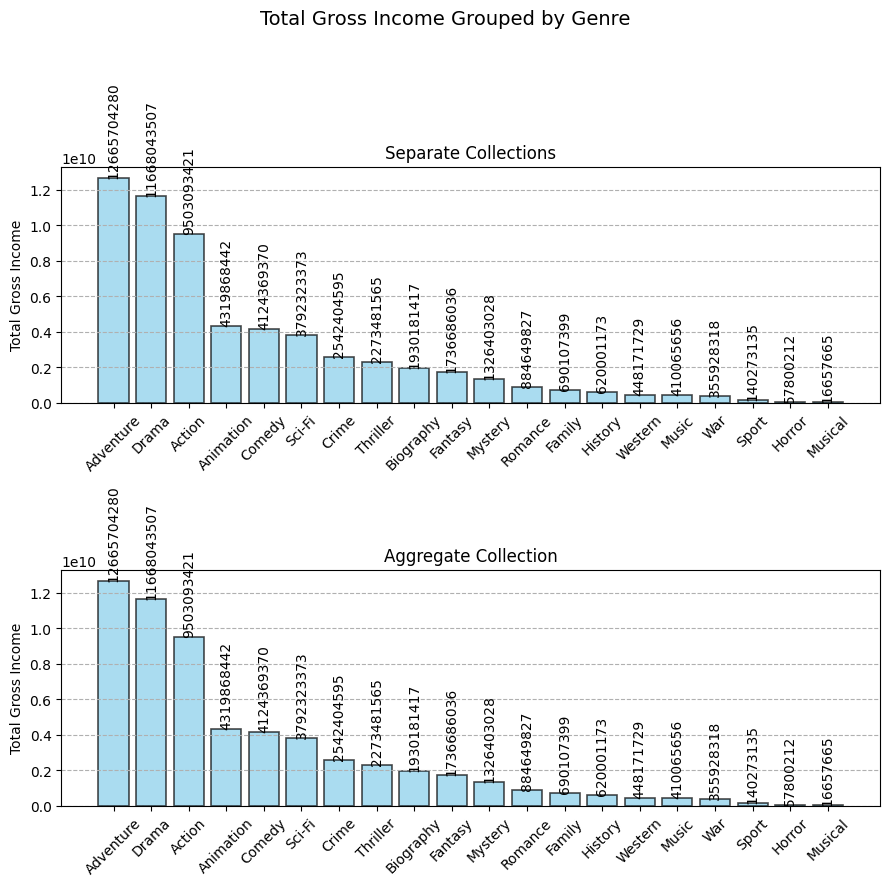

In [10]:
# Plot the previous results
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
fig.suptitle('Total Gross Income Grouped by Genre', fontsize=14)

# First subplot: Separate collections
axs[0].bar(genres.keys(), genres.values(), color='skyblue', edgecolor='black', linewidth=1.2, alpha=0.7)
axs[0].set_title('Separate Collections', fontsize=12)
axs[0].set_ylabel('Total Gross Income', fontsize=10)
axs[0].grid(axis='y', linestyle='--', which='major')
for i, v in enumerate(genres.values()):
    axs[0].text(i, v + 0.4, str(v), color='black', ha='center', rotation=90, va='bottom')  # Rotate labels on bars
axs[0].tick_params(axis='x', rotation=45)

# Second subplot: Aggregate collection
axs[1].bar(all_genres.keys(), all_genres.values(), color='skyblue', edgecolor='black', linewidth=1.2, alpha=0.7)
axs[1].set_title('Aggregate Collection', fontsize=12)
axs[1].set_ylabel('Total Gross Income', fontsize=10)
axs[1].grid(axis='y', linestyle='--', which='major')
for i, v in enumerate(all_genres.values()):
    axs[1].text(i, v + 0.4, str(v), color='black', ha='center', rotation=90, va='bottom')  # Rotate labels on bars
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Speedup

In [11]:
# print the speedups for all questions and the average speedup

print('Speedups for all questions:')
print_beautify(speedups)
average_speedup = sum(speedups.values()) / len(speedups.keys())
print('Average speedup: ', average_speedup, '%')

Speedups for all questions:
{
    "question1": 311.0786008777763,
    "question2": 153.47009099230064,
    "question3": 270.1049611115306,
    "question4": 294.58093334900667,
    "question5": 301.4233697451175,
    "question6": 380.61946902654864
}
Average speedup:  285.2129041837134 %


Come si può notare, in una normale esecuzione, l'esecuzione della query sulla collection che contiene tutti i film è circa 3 volte più veloce rispetto che eseguire la stessa query sulle tre diverse collezioni.
Per mantenere quindi entrambe le versioni verrebbe logico non dividere i diversi film per certificato, bensì tenerli in una sola collezione

# Algoritmo di raccomandazione

predilezione per il genere Sci-Fi e Adventure, ma non ami particolarmente i film troppo lunghi. Proporre un algoritmo di raccomandazione basato su queste preferenze e che gli suggerisca 3 film da guardare. Come si classificherebbe tale algoritmo?

In [12]:
import random

genres = ['Adventure', 'Drama', 'Action', 'Animation', 'Comedy', 'Sci-Fi', 'Crime', 'Thriller', 'Biography', 'Fantasy', 'Mystery', 'Romance', 'Family', 'History', 'Western', 'Music', 'War', 'Sport', 'Horror', 'Musical']

user_preferences = {genre: random.randint(10, 80) / 100.0 for genre in genres}
user_preferences['Adventure'] = 0.97
user_preferences['Sci-Fi'] = 0.95
preferred_runtime = 90

pipeline = [
        {
            "$project": {
                "Series_Title": 1,
                "Genre": {
                    "$map": {
                        "input": {"$split": ["$Genre", ","]},
                        "as": "g",
                        "in": {"$trim": {"input": "$$g"}}
                    }
                },
                "Runtime": {
                    "$toInt": {
                        "$arrayElemAt": [{"$split": ["$Runtime", " "]}, 0]
                    }
                },
                "IMDB_Rating": 1
            }
        }
    ]

films = list(db[all_films_coll].aggregate(pipeline))

def reccomendation_system(films, user_preferences, preferred_runtime):
    recommendations = {}

    for film in films:
        similarity = 0
        for genre in film['Genre']:
            if genre in user_preferences:
                similarity += user_preferences[genre]
        
        similarity /= len(film['Genre'])
        if film['Runtime'] <= preferred_runtime:
            time_score = film['Runtime'] / preferred_runtime
        else:
            time_score = max(0, 1 - (film['Runtime'] - preferred_runtime) / preferred_runtime)
        similarity = (similarity + time_score) / 2

        recommendations[film['Series_Title']] = {
            "Runtime": film['Runtime'],
            "IMDB_Rating": film['IMDB_Rating'],
            "Similarity": similarity
        }

    recommendations = dict(sorted(recommendations.items(), key=lambda item: item[1]["Similarity"], reverse=True))

    return recommendations

# Get recommendations
tmp = reccomendation_system(films, user_preferences, preferred_runtime)
top_recommendations = dict(list(tmp.items())[:3])

print_beautify(top_recommendations)



{
    "The Grand Budapest Hotel": {
        "Runtime": 99,
        "IMDB_Rating": 8.1,
        "Similarity": 0.8583333333333334
    },
    "Aladdin": {
        "Runtime": 90,
        "IMDB_Rating": 8.0,
        "Similarity": 0.8316666666666667
    },
    "Monsters, Inc.": {
        "Runtime": 92,
        "IMDB_Rating": 8.1,
        "Similarity": 0.8205555555555555
    }
}


### Spiegazione

L'algoritmo di raccomandazione creato è basato sui contenuti.
In particolare, si presuppone che sia possibile ricavare da dati preesistenti la valutazione media di ogni utente per ogni genere (in questo caso creata in maniera random). Si presuppone inoltre una durata preferita dall'utente in modo da indirizzare l'algoritmo verso i film di durata simile.

### Per ogni film:

1. **Somiglianza con le preferenze sui generi**
    - Somma i punteggi delle preferenze dell'utente per ogni genere del film (se presente nelle preferenze).
    - Divide la somma per il numero totale di generi del film per ottenere una media.

2. **Score basato sulla durata**
    - Calcola uno score in base alla distanza tra la durata del film e la durata preferita dell'utente. La formula:

    $$\text{time\_score} = 1 - \frac{|\text{Runtime} - \text{preferred\_runtime}|}{\text{preferred\_runtime}}$$


    - Penalizza film molto più lunghi o corti rispetto alla durata preferita.

3. **Score finale**
    - Media tra la somiglianza sui generi e lo score della durata:

    $$\text{similarity} = \frac{\text{similarity\_genre} + \text{time\_score}}{2}$$

4. **Ordinamento delle raccomandazioni**
   - I film sono ordinati in base al punteggio di somiglianza (in ordine decrescente)

L'algoritmo di raccomandazione sviluppato, propone film diversi ad ogni esecuzione. Questo è possibile solo grazie alla generazione random delle valutazioni.
In un contesto reale, le raccomandazioni potrebbero variare soltanto se le votazioni dell'utente cambiano. Per evitare questo fenomeno si potrebbe fare una scelta random sui primi N film più simili alle specifiche


In [16]:
#Verificare se esistono nel database dei film classificati sia come Sci-Fi e Adventure, che non 
# durano più di 90 minuti. Se sì, visualizzare i primi 3 (in base al rating)

def verify():
    pipeline = [
        {
            "$project": {
                "Series_Title": 1,
                "Genre": {
                    "$map": {
                        "input": { "$split": ["$Genre", ","] },
                        "as": "g",
                        "in": { "$trim": { "input": "$$g" } }
                    }
                },
                "Runtime": 1,
                "IMDB_Rating": 1
            }
        },
        {
            "$match": {
                "Genre": { "$all": ["Sci-Fi", "Adventure"] },
                "Runtime": { "$lte": 90 }
            }
        },
        {
            "$project": {
                "Series_Title": 1,
                "IMDB_Rating": 1
            }
        },
        {
            "$sort": {
                "IMDB_Rating": -1
            }
        },
        {
            "$limit": 3
        }
    ]

    films = list(db[all_films_coll].aggregate(pipeline))
    return films

films = verify()
if len(films) < 1:
    print("There are no films that match the criteria")
else:
    print(films)

There are no films that match the criteria


La query precedente mostra che non sono presenti a database film che appartengono al genere "Sci-fi" e "Adventure" e che contemporaneamente abbiano una durata complessiva minore di 90 minuti.

Per questo motivo per valutare l'efficacia dell'algoritmo di valutazione, se ne creano alcuni (fittizzi) che rispettino le specifiche.

In [14]:
fake_names = ['The Matrix', 'Star Wars: Episode IV - A New Hope', 'Star Wars: Episode V - The Empire Strikes Back', 'Star Wars: Episode VI - Return of the Jedi', 'Guardians of the Galaxy', 'Guardians of the Galaxy Vol. 2', 'The Martian', 'Interstellar', 'Inception', 'Avatar']
fake_genres = ['Sci-Fi', 'Adventure']
fake_runtimes = [int(random.uniform(80, 100)) for _ in range(10)]

fake_film = {}
for i in range(10):
    film = {
        'Series_Title': fake_names[i],
        'Genre': fake_genres,
        'Runtime': fake_runtimes[i],
        'IMDB_Rating': round(random.uniform(7, 10), 1)
    }
    fake_film[fake_names[i]] = film

tmp = reccomendation_system(list(fake_film.values()), user_preferences, preferred_runtime)
top_recommendations = dict(list(tmp.items())[:3])

print_beautify(top_recommendations)

{
    "Inception": {
        "Runtime": 90,
        "IMDB_Rating": 10.0,
        "Similarity": 0.98
    },
    "The Matrix": {
        "Runtime": 92,
        "IMDB_Rating": 7.5,
        "Similarity": 0.9688888888888889
    },
    "Guardians of the Galaxy": {
        "Runtime": 88,
        "IMDB_Rating": 8.4,
        "Similarity": 0.9688888888888889
    }
}


Come è visibile dai risultati, il sistema di raccomandazione ha suggerito i film "The Martian", "Interstellar" e "Inception" come i migliori film da vedere. Questo è dovuto al fatto che questi film appartengono ai generi "Sci-Fi" e "Adventure" e hanno una durata simile ai 90 minuti